In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import sys
from glob import glob

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
train_path = r"D:\OWN_CODES\003. Deep Learning\001. Lazy Prog TF 2\FoodData\train"
valid_path = r"D:\OWN_CODES\003. Deep Learning\001. Lazy Prog TF 2\FoodData\test"

In [3]:
IMAGE_SIZE = [200,200]

In [4]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [5]:
folders = glob(train_path + '/*')

In [6]:
ptm = PretrainedModel(
        input_shape = IMAGE_SIZE + [3],
        weights = 'imagenet',
        include_top = False

)

In [8]:
x = Flatten()(ptm.output)

In [9]:
model = Model(inputs = ptm.input , outputs = x)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [11]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
batch_size = 128

In [14]:
train_gen = gen.flow_from_directory(
        train_path,
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'binary'

)

test_gen = gen.flow_from_directory(
        valid_path,
        target_size = IMAGE_SIZE,
        batch_size = batch_size,
        class_mode = 'binary'

)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Create tabular features for computing Z only once

In [15]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

In [16]:
# Now we should figure out the output size of Z stage

feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))

In [17]:
D = feat.shape

In [18]:
D

(1, 18432)

In [19]:
D = feat.shape[1]

In [20]:
D

18432

In [21]:
X_train = np.zeros((Ntrain,D))
y_train = np.zeros(Ntrain)

In [22]:
X_valid = np.zeros((Nvalid,D))
y_valid = np.zeros(Nvalid)

In [23]:
i = 0 

for x,y in train_gen:
    features = model.predict(x)
    sz = len(y)
    
    X_train[i:i+sz] = features
    y_train[i:i+sz] = y
    
    i+=sz 
    
    print(i)
    
    if i>= Ntrain:
        print("Done")
        break

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
Done


In [24]:
X_train.max() , X_train.min()

(650.8262939453125, 0.0)

In [25]:
i = 0 

for x,y in test_gen:
    features = model.predict(x)
    sz = len(y)
    
    X_valid[i:i+sz] = features
    y_valid[i:i+sz] = y
    
    i+=sz 
    
    print(i)
    
    if i>= Nvalid:
        print("Done")
        break

128
256
384
512
640
768
896
1000
Done


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [28]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression()

logr.fit(X_train2 , y_train)

print(logr.score(X_train2, y_train))
print(logr.score(X_valid2, y_valid))

1.0
0.979


In [29]:
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)

linearModel = Model(i,x)



In [34]:
linearModel.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
)

In [35]:
r = linearModel.fit(
        X_train,y_train,
        batch_size = 128,
        epochs = 10,
        validation_data = (X_valid,y_valid)
)

Epoch 1/10
24/24 [==============================] - 1s 28ms/step - loss: 1.4084 - accuracy: 0.9100 - val_loss: 0.2787 - val_accuracy: 0.9740
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0724 - accuracy: 0.9923 - val_loss: 0.3087 - val_accuracy: 0.9720
Epoch 3/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.2860 - val_accuracy: 0.9760
Epoch 4/10
24/24 [==============================] - 0s 11ms/step - loss: 5.8070e-04 - accuracy: 0.9997 - val_loss: 0.3444 - val_accuracy: 0.9720
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 3.4953e-05 - accuracy: 1.0000 - val_loss: 0.3351 - val_accuracy: 0.9730
Epoch 6/10
24/24 [==============================] - 0s 12ms/step - loss: 6.6772e-06 - accuracy: 1.0000 - val_loss: 0.3327 - val_accuracy: 0.9730
Epoch 7/10
24/24 [==============================] - 0s 12ms/step - loss: 5.2443e-06 - accuracy: 1.0000 - val_loss: 0.3312 - val_accuracy: 0.97

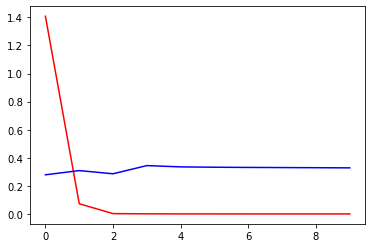

In [36]:
plt.plot(r.history['loss'] , color = 'red' , label = 'loss')
plt.plot(r.history['val_loss'] , color = 'blue' , label = 'val_loss')
